## Elementary Examples in Inverse Dynamics

Falk Mielke, FunMorph, Universiteit Antwerpen

You can download this notebook [here](user://notebooks/ID_LMX0a_Wrenches.ipynb?download&target=_blank).

This is one part of a series of blog posts on Inverse Dynamics.
- [Prologue A: Wrench Town Rock](../id_lmx0a_wrenches)
- [Prologue B: The Fictitious Force Awakens](../id_lmx0b_fforces)
- [Elementary Example 1: Stuttering Motor (Euler Force)](../id_lmx1_stutter)
- [Elementary Example 2: Needle On A Vinyl (Centrifugal Force)](../id_lmx2_vinyl)
- [Elementary Example 3: Radial Slider (Coriolis Force)](../id_lmx3_slider)
- [Application: N-Link Inverse Dynamics](../id_lmx4_nlink)

# Wrench Town Rock

The purpose of this first notebook is to introduce the general notation by demonstrating how calculations can be performed in `python`/`sympy`. 
Along the way, I assemble a `Wrench` object for re-use in the following notebooks. 

Wrenches are a natural combination of forces and moments ("moment" is synonymous to "torque"). 
Because moments are just forces acting at a lever, it makes intuitive sense that they are joined in a single vector quantity (which is a 6D vector). 
Despite this intuitive sense and simplicity of calculation, I had never heard about wrenches, nor the bigger framework, [Screw Theory](https://en.wikipedia.org/wiki/Screw_theory?target=_blank), prior to my PhD work.



This notebook is intended to help readers familiarize with `sympy` and my notation. 
If you feel like an expert, feel free to skip ahead to the [next notebook](../id_lmx0b_fforces). 

# Where To Start?

The goal of this series of notebooks is to have elementary examples that demonstrate the calculation of multibody dynamics. I am interested in the inverse problem$^{*}$, i.e. calculating internal forces of a more or less idealized system of rigid bodies, given that the interaction of that system with its environment is zero or can be measured. 

$^{*}$ The opposite, called "forward problem/dynamics", would be simulating rigid body dynamics without measuring it.


In the course of my project on piglet locomotion, I started looking for a way to calculate inverse dynamics. 
I found many academic papers and books that could serve as starting points. 

However, I have three requirements when following algorithms:
- there must be some sort of derivation (even if I don't understand each detail) or reference to such.
- code must be available and sufficiently documented (no matter which programming language)
- a numeric example should be provided.

The reason that I demand to see these things is the pure, pragmatic principle of reproducibility.
And, sadly, that simple principle boiled down the possible role model analyses which I could use for my purpose. 


I found one concise article by Raphael Dumas and colleagues ([Dumas *et al.* , 2004](https://doi.org/10.1080/10255840410001727805?target=_blank)). And luckily, the author made a matlab toolbox available just last year (Dumas , 2019). 
I initially followed them in a sense that (i) I first calculate everything in an inertial frame of reference, (ii) I use wrenches, and that (iii) the algorithm below could trivially be generalized to use quaternions (by [using a different variant](https://docs.sympy.org/latest/modules/physics/vector/api/classes.html?target=_blank#sympy.physics.vector.frame.ReferenceFrame.orient) of the `ReferenceFrame.orient()` method in `sympy`). 
And with some minor struggle, I was able to port the relevant part of the calculation to `python`, which gave me a starting point for what you will find below.

The Dumas works to not tackle some interesting questions regarding reference frames and fictitious forces. I hope to solve them in this series of notebooks.


I therefore extended my reach to the book ["Modern Robotics" by Kevin M. Lynch and Frank C. Park](http://www.modernrobotics.org?target=_blank) (Lynch and Park, 2017). 
My work is related to chapters 3 and 8 therein. 
There is also [a set of videos](https://www.youtube.com/playlist?list=PLggLP4f-rq02vX0OQQ5vrCxbJrzamYDfx&target=_blank) which accompany the book. 
What I particularly like about the "modern robotics" book is that it assembles consistent notation, and that it builds up towards complex concepts from understandable basics. 

Although the book comes with python code, I decided to build up from basic `sympy` as long as I do not need the full beauty of twist/wrench notation.

Finally, there is a [great tutorial](https://www.youtube.com/watch?v=r4piIKV4sDw?target=_blank) from a previous the Scipy Conference by Jason Moore (Moore *et al.*, 2016) which I can recommend if you'd like to familiarize with `python`/`sympy`. 
Moore is also a contributor to `sympy`. 
They also have a relevant "human standing" example in [the pydy toolbox](https://github.com/pydy/pydy-tutorial-human-standing?target=_blank). 

These are excellent resources that I can fully recommend to those who seek to understand dynamics. 

# Preparation
## Ingredients

Take the following situation:


<img src="images/id_lmx_0.svg" width="500px"> </img>

A point mass rotates around a central joint at constant angular velocity. 
We have the momentary angle $\varphi$, and an angular velocity $\dot\varphi$ that is defined by taking a period $T$ and calculating 

$ \dot\varphi = \frac{2\pi}{T} $


Time is noted as $t$.

We also have a point mass (of mass $m$) at position $P$, which is distance $l$ away from the joint $J$. 

Two reference frames are used as a helper for this problem. I use the curly brackets as a shorthand notation for a reference frame (e.g. static frame $\{S\}$), but omit brackets for indices in code. 
Most important, the inertial frame, or static frame, is $\{S\}$, and it defines our global coordinate system. 
Its origin is arbitrarily placed at the joint. 

Secondly, there is a rotating frame $\{B\}$ attached to the rotating point mass. 
Or actually, it is rather attached to the rotating joint-pointmass axis. Whether I place the origin to the joint, to the body, or somewhere in between does not matter. 
In fact, a non-static frame does not need an origin. 
It only needs a rotation. 
The origin is naturally given as the center of rotation, but when that is put to formulas and code, the center of rotation comes from the relation of points (e.g. here: the joint does not move with respect to the origin). 
Whether you think of a reference frame as just a set of arbitrarily placed basis vectors, or as basis vectors and an origin, is up to you, as long as you know what is going on in the problem.

Speaking of basis vectors: both frames are of course right handed and have unit vectors $\hat{x}_i$ with $i \in \{1,2,3\}$ (analogous to $x,y,z$). 

Because I like science fiction, gravity is zero instead of ten for this and the following example problems. 
Also, $\pi \equiv 3$ wlog.

## Initialization

This example system can be calculated with symbolic procedures in `sympy` as follows below.

Several libraries are required:

In [1]:

import numpy as NP # numerics
import sympy as SYM # symbolic operations
import sympy.physics.mechanics as MECH # some physics/mechanics tools
import matplotlib.pyplot as MPP # plotting

# printing of formulas
SYM.init_printing(use_latex='mathjax', pretty_print = False)
MECH.init_vprinting(use_latex='mathjax', pretty_print = False)


And a few helper functions will be useful.  

In [2]:
# shorthand to get the basis of a reference frame
GetCoordinates = lambda rf: [rf[idx] for idx in rf.indices]

# create a vector from components
ComponentsToVector = lambda components, rf: \
                        sum([ elm*c for elm, c in zip(components, GetCoordinates(rf)) ])


# transforming a sympy vector to a matrix
MatrixToVector = lambda mat, rf: sum([elm * base for elm, base in zip(mat, GetCoordinates(rf)) ])


# shorthand for getting an inertia dyadic ("tensor") from a matrix
InertiaMatrixToDyadic = lambda mat, ref_frame:\
        MECH.inertia(ref_frame, mat[0,0], mat[1,1], mat[2,2], mat[0,1], mat[1,2], mat[2,0])



# Steiner's Theorem, generalized form 
# [modern robotics, page 245]
GeneralizedSteiner = lambda mass, columnvector: \
                        SYM.simplify( \
                             mass * ( (columnvector.T*columnvector)[0] * SYM.eye(3) \
                                      - columnvector*columnvector.T \
                                    ) \
                             )

I will use **vector logic** for all of the calculations below. So all of the non-scalar variables will be (column) vectors or matrices, in $\mathbb{R}^3$.

## General Procedure

My general procedure involves a pragmatic execution of the following steps:
- define variables
- relate reference frames
- identify points of interest and their relative position
- assemble inertial properties
- extract kinematics
- kinetics/inverse dynamics
- visualization and cross-checking of intermediate steps



# Definition of Variables

According to the sketch above, we define the following variables. Note that we enter time explicitly here (one could instead use the `MECH.dynamicsymbols` function, but I prefer the explicit time dependence for demonstration).

In [3]:
# time, length, mass, gravitational acceleration
t, l, m = SYM.symbols('t, l, m', real = True)

# set the period of rotation
period = SYM.symbols('T', real = True)

# this defines the angular velocity by 2π/T
φdot = 2*SYM.pi/period

# the angle φ is a function of time
φ = SYM.Function('φ')(t)

# the angular velocity is equal to the first derivative of the angle
# so by integrating it, we get the angle.
φ_function = SYM.integrate(φdot, t)

# we will store this for substitution later, 
# for being able to calculate with angles, and then break it down to time.
φ_substitutes = {φ: φ_function}

φ_substitutes

{φ: 2*pi*t/T}

Some of the values are constant, and we would like to substitute those in sometimes to numerically inspect our example.

In [4]:
constants = {  l: 1. # m \
             , m: 1. # kg \
             , period: 2.*SYM.pi # s \
             , SYM.pi: NP.pi # = 3.0 \
            }

# this function will substitute and simplify
PlugAllIn = lambda expression: SYM.simplify(SYM.nsimplify(SYM.simplify( \
                                  expression.subs(φ_substitutes).doit().subs(constants).subs(constants) \
                                )))

# Reference Frames

To describe this basic situation, I decided to define two reference frames ($\{S\}$ and $\{B\}$, see above).

The choice of reference frames is actually a design decision: in principle, I could connect reference frames to any space I like. I could even choose one that is unrelated to the problem, but that would be a bit arbitrary. I rather tend to choose the ones which I think (from my experience, and from trying around) will facilitate the calculation.


The first reference frame in this example is $\{S\}$ = static frame = inertial frame = earth-bound frame (though if it were earth, gravitation would be required). 
I call it "world".

In [5]:
world = MECH.ReferenceFrame('S')


A second frame is bound to the object of study (body frame $\{B\}$), and rotates with it relative to the static frame. 
This situation is intuitively matched by the way non-static reference frames are defined in `sympy`: we start with the `world` frame and orient a new one relative to it (`orient` or `orientnew`). 
Here, new orientation is given by angle $\varphi$ round the common $\hat{x}_3 = \hat{z}$ axis. 
An [alternative, more general variant](https://docs.sympy.org/latest/modules/physics/vector/api/classes.html?target=_blank#sympy.physics.vector.frame.ReferenceFrame.orient) of `orient` would involve quaternions. 

Not only the rotation, but also the velocity and acceleration have to be defined (even if one uses `dynamicsymbols`).

In [6]:
# initialize the {B} frame as rotated relative to the world by φ around the world's z axis.
body = world.orientnew('B', 'Axis', (φ, world.z))

# we give the body frame angular velocity and acceleration
body.set_ang_vel(world, φdot*world.z)
body.set_ang_acc(world, φdot.diff(t)*world.z) # should be zero in our case

body.ang_vel_in(world).to_matrix(world).T

Matrix([[0, 0, 2*pi/T]])

To transform from one frame to the other, we can get transformation matrices. They are abbreviated $R_{SB}$ where R stands for the matrix (it's just rotation matrices, actually) and the index $SB$ means that we transform from frame $B$ to frame $S$ (Lynch and Park, 2017, help to remember this as "subscript cancellation", i.e. R<sub>S</sub><sub><s>B</s></sub> v<sub><s>B</s></sub> = v<sub>S</sub>).
Those have to be left-multiplied to a point|vector|matrix to transform it from the world to the body frame ("BS") or the other way round ("SB"). 
I wrap them in a dictionary, because I find that an intuitive way to acces all the cross combinations of transform matrices that appear when working with more than two reference frames.

In [7]:
# prepare a list of (label/frame) tuples.
frames = [('S', world), ('B', body)]

# "trafo" dict will store transformation matrices "to" any frame "from" another frame.
trafo = {label: {} for label, _ in frames}
for label_from, frame_from in frames:
    for label_to, frame_to in frames:
        trafo[label_to][label_from] = SYM.simplify(frame_to.dcm(frame_from))

# display example
PlugAllIn(trafo['S']['B'])

Matrix([
[cos(t), -sin(t), 0],
[sin(t),  cos(t), 0],
[     0,       0, 1]])

Try to mentally plug in specific time points ($t=0$, $t=\frac{\pi}{2}$, ...) to confirm that this matrix makes sense, and even more important to see that all signs and directions are plausible.

# Points

Our toy system has two points of interest: 
- the world origin ($O$, which coincides with the rotational pivot that I call "joint" $J$)
- a point mass ($P$, also centers of mass) at distance $l$ from the joint

As with reference frames, these points are chosen for logical convenience. 

Here is how the points and their relation to the reference frames are defined in `sympy`, starting with the origin.

In [8]:
# define the origin
origin = MECH.Point('O')

# the origin does not move in the inertial frame
origin.set_vel(world, 0)
origin.set_acc(world, 0)




Then I choose to also define a joint, which coincides with the origin, but is located in the rotating body frame.

In [9]:


### define joint
joint = MECH.Point('J')

## set position of joint
joint.set_pos(origin, sum([0*n for n in GetCoordinates(world)]))

## set position derivatives
# (i) in the body frame
joint.set_vel(body, 0)
joint.set_acc(body, 0)


# (ii) in the static frame
joint.set_vel(world, joint.pos_from(origin).diff(t, world).simplify())
joint.set_acc(world, joint.vel(world).diff(t, world).simplify())



Finally, the point mass needs to be set up.

In [10]:

# a pointmass
pointmass = MECH.Point('P')


# position: at distance l from the origin
pointmass.set_pos(joint, l * body.y)

# points do not move relative to the body frame
pointmass.set_vel(body, pointmass.pos_from(joint).diff(t, body).simplify())
pointmass.set_acc(body, pointmass.vel(body).diff(t, body).simplify())

# set velocity of point in static rf
pointmass.set_vel(world, pointmass.pos_from(origin).diff(t, world).simplify())
pointmass.set_acc(world, pointmass.vel(world).diff(t, world).simplify())


## The velocity of the points in the world could be determined "automatically" from settings above
# point.v2pt_theory(origin, world, body)
## But beware: this lead to trouble for me
# see http://www.aoengr.com/Dynamics/RotatingReferenceFrame.pdf
#     http://www.aoengr.com/Dynamics/CoriolisAcceleration.pdf
## so I recommend not to use it carelessly.
    
# print the point accelerations
SYM.pprint(PlugAllIn(pointmass.acc(world).express(world).to_matrix(world)).T)

[sin(t)  -cos(t)  0]


Note that it is good to know kinematic equations for all points in all reference frames. 
A well-initialized `sympy` system helps intuitively to keep track of these relations. 

We have defined analytic kinematic equations here so that we know precisely what is going on. 
In a real problem, these definitions would be analogous. 


# Inertial Properties

The objects that we assemble in our calculations are, in general, rigid bodies. Hence, their inertial properties must be regarded. 

Here, we have a point mass. Its Mass Moment of Inertia $I$ is the zero matrix ([see here](https://en.wikipedia.org/wiki/List_of_moments_of_inertia?target=_blank)). However, relative to the joint, it would have a "parallel axis" component which one can calculate by using Steiner's Theorem. Again, I use dictionaries to store the different variants.

In [11]:
# zero inertia relative to the com (because we have point masses)
inertia = MECH.inertia(body, 0, 0, 0)

I_B = {}
# the system has an inertia relative to the origin, which coincides with the center of mass.
for pt, refpoint in [('P', pointmass), ('J', joint), ('O', origin)]:
    I_B[pt] = inertia.to_matrix(body)\
                + GeneralizedSteiner(  m, pointmass.pos_from(refpoint).express(body).to_matrix(body) ) 


# all the I's can be transformed to the inertial reference frame
I_S = {}
for refpoint in I_B.keys():
    I_S[refpoint] = SYM.simplify(trafo['S']['B'] * I_B[refpoint] )

# print an example
PlugAllIn(I_S['J'])

Matrix([
[cos(t), 0, 0],
[sin(t), 0, 0],
[     0, 0, 1]])

`Sympy` allows to put all this into a rigid body, which however I will not use further on. 
Nevertheless, being able to successfully initiate a rigid body is a good sign that you have *some* system ready for kinematics.

In [12]:
point_rb = MECH.RigidBody('point' \
                      , pointmass \
                      , world \
                      , m \
                      , (InertiaMatrixToDyadic(I_S['P'], world), pointmass) \
                     )

## Intermediate Summary
The goal of the previous initializations is to have all rigid bodies assembled. This requires the definition of constants, time-dependent variables, reference frames, points and their relation in the reference frames, and finally the assembly of rigid bodies and their inertial properties. 

In short, this step can be described as "condensing down the complex world to a system of com's, joints, and reference frames".

# Kinematics

The analysis of kinematics extracts information on how the objects of interest move over time. There exists linear movement (e.g. movement of the center of mass/COM and point masses) and angular movement (i.e. rotation of the rigid body around its COM).

In a real problem, kinematics would be measured by videography, plus the determination of the COM position from (3D) images. 
Because the COM is not distinct or even visible (it is abstract), one usually traces landmarks and triangulates the COM with information form structural information (e.g. μCT scans).

Here, we use the exact analytic description of the point movements. We get the kinematics "as if we would have observed them".

## Linear Kinematics

If everything was well defined above, the time-dependent position vector of the body is easy to determine.

In [13]:
x = pointmass.pos_from(origin).express(world).to_matrix(world)
xdot = pointmass.vel(world).to_matrix(world)
xdotdot = pointmass.acc(world).to_matrix(world)
PlugAllIn(xdotdot).T

Matrix([[sin(t), -cos(t), 0]])

## Angular Kinematics

We have initialized the rotation with angle $\varphi$ above, and defined it as the rotation of the body frame in the world. 
This is the only angle in the problem, so $\{B\}$ rotation about the joint is $\varphi (t)$. 
However, in general, there might be superimposed rotations (e.g. n-link robot arms). So it is useful to define $\omega$ as the rotation of a reference frame in the world.

In [14]:
ω = SYM.Matrix([[0],[0],[φ]])
ωdot = body.ang_vel_in(world).to_matrix(world)
ωdotdot = body.ang_acc_in(world).to_matrix(world)

(Note that the momentary angle $\omega$ is not used below.)

Here you saw the benefit of a well-defined problem. 
Once everything is in place, the rest of the algorithm follows fluently. 

# Visualization

It might be useful to plot the trajectories, to see whether they match your intuitive expectation.

To get numeric values from symbolic evaluations, `sympy` offers the "`lambdify`"-Functionality. Give it a list of independent variables, and a term that relates those, and `lambdify` returns a numeric function where one can plug in values.

In [15]:
time = NP.linspace(0., 2*NP.pi, 60, endpoint = False)
position = SYM.lambdify(t, PlugAllIn(x), 'numpy')
lin_velocity = SYM.lambdify(t, PlugAllIn(xdot), 'numpy')
lin_acceleration = SYM.lambdify(t, PlugAllIn(xdotdot), 'numpy')
ang_velocity = SYM.lambdify(t, PlugAllIn(ωdot), 'numpy')
ang_acceleration = SYM.lambdify(t, PlugAllIn(ωdotdot), 'numpy')
# position(time)

It might be nice to color by time (or velocity, or randomly - choose what you think is instructive).

In [16]:
y = [pos[0] for pos in position(time)] 
v = time.reshape((-1,1))
v_mag = NP.sqrt(NP.sum(NP.power(v, 2), axis = 1))
v_cval = v_mag - NP.min(v_mag)

<lambdifygenerated-1>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return (array([[-sin(t)], [cos(t)], [0]]))


And here is a simple 2D plot:

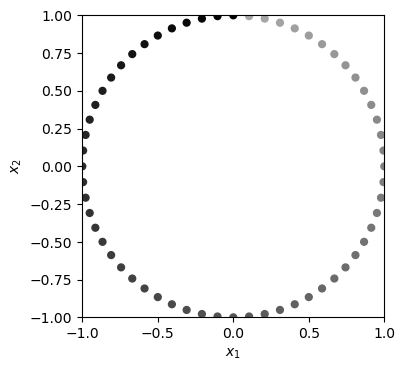

In [17]:

fig = MPP.figure(dpi = 100)
ax = fig.add_subplot(1,1,1,aspect = 'equal')
ax.scatter(y[0], y[1], s = 24 \
           , color = [(val, val, val) for val in 0.66*v_cval/NP.max(v_cval)] \
           , marker = 'o' \
           , alpha = 1. \
          )
ax.set_xlim(NP.array([-1,1])*(constants[l]))
ax.set_ylim(NP.array([-1,1])*(constants[l]))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
MPP.show();

What a fancy way to draw a watch. 
Yet I hope you learned that `lambdify` is a quite efficient way to turn symbolic solutions into numeric functions.

Now for the exciting part: the actual dynamics.

# Kinetics / Inverse Dynamics

When the rigid bodies are assembled and the kinematics are extracted, one can determine how forces acted on the objects of interest to produce the movements that were observed.

## Balance of Forces

The first step in each iteration of inverse dynamics is usually to determine the "Balance of Forces" of a free body in the inertial reference frame. 

*What is Balance of Forces about?* Well, we can say with confidence that:

**The time change of momentum of a rigid body is equal to the sum of external forces acting on it.** This is the conservation of momentum.

Or in terms of formulas:

The momentum $p$ is defined as the product of the mass $m$ and the linear velocity $\dot{x}$.

$ p = m \dot{x} $


The sentence above (Forces $F$, time $t$) can be stated as 

$\sum F_{ext} = \frac{dp}{dt}$


Then, we use the total derivative to see how the momentum changes over time.

$ \frac{dp}{dt} = m\cdot\frac{\partial \dot{x}}{\partial t} + \frac{\partial m}{\partial t} \cdot \dot{x}$


Then there is a "dirty trick", using the chain rule to split $\frac{\partial m}{\partial t}$:

$\frac{\partial m}{\partial t} = \frac{\partial m}{\partial x} \cdot \frac{\partial x}{\partial t}$


Which gives

$ \sum F = m\ddot{x} + \frac{\partial m}{\partial x} \dot{x}\dot{x}  $


I'm still puzzled about the $\frac{\partial m}{\partial x}\dot{x}\dot{x}$ part above, and will ignore it for now (mass is a constant, deriving at zero). 
I used to learn about it at university, with examples of rockets losing fuel on the way. 
The term is also somehow related to "velocity product terms" that appear from the Lagrangian formalism, as described in the [modern robotics] book. $\frac{\partial m}{\partial x}$ are the [Christoffel symbols](https://en.wikipedia.org/wiki/Christoffel_symbols?target=_blank), i.e. partial derivatives of the mass matrix. 
A robot arm does not loose fuel, but it may (partially) change configuration. 

Unfortunately, I could not find a conclusive explanation of the term. 
I will certainly revisit the book and try to understand better at some point. 
If a reader could provide a pointer to further information, I would much appreciate it. 

I initially thought the term would have to do with the fictitious forces (because Coriolus and Centrifugal force also involve products of velocities; and the description in [modern robotics] implies it). 
However, from my example calculations, that connection is not immediately obvious.

In situations where that partial is zero, we are left with 

$ \sum F = m\ddot{x} $

Certainly, you recognize the formula. 
In our example, the mass is given, and the acceleration was determined by kinematics. 
Most external forces (e.g. gravity) are zero because we chose this as a setting. 
The only external force that applies is the one on the joint (here: origin), which we would like to determine. 

Here comes the Balance of Forces in `sympy`.

**The following sub-procedure will be repeated several times in my notebooks:** define symbols for the unknown force/moment, assemble balance equations, and solve for the symbols. 
I must say that I find it a relief that I don't have to carry out all the calculations with pen and paper.  

We first initialize symbols for the unknown joint force which we are interested in.

In [18]:
# define symbols for the force of interest
joint_force = SYM.Matrix(SYM.symbols('f_{JS1:4}', real = True))
joint_force.T

Matrix([[f_{JS1}, f_{JS2}, f_{JS3}]])

Then, we use the `solve` function from `sympy` to solve the balance equation.

In [19]:
force_solutions = {}

# we'll equate the mass/acceleration of our free body to the joint force.
BoF_equation = SYM.Eq(m*xdotdot, joint_force)

# we can then solve for all spatial components of the force vector
for component, sol in SYM.solve(BoF_equation, joint_force).items():
    force_solutions[component] = sol

# Finally, the outcome can be stored in a vector.
F_J = SYM.Matrix([force_solutions[f] for f in joint_force])
SYM.pprint(PlugAllIn(F_J).T)

[sin(t)  -cos(t)  0]



The joint force in this first calculation is non-zero, which is plausible because the point mass does change movement (i.e. inertia) by being forced to a circular orbit around the joint. 


*Do you recognize the force we found here?* If your answer is "not immediately", maybe transforming it to the body frame will ring a bell, because there it only goes in a certain direction.


## Balance of Moments

The formulas that determine the Balance of Forces can be found analogously for rotational motion ([cf. Euler's laws of motion](https://en.wikipedia.org/wiki/Euler%27s_laws_of_motion?target=_blank)).

We have conservation of angular momentum $L$ (with moment of inertia $I$ and angular velocity $\dot{\omega}$):

$L = I\dot{\omega} $

The time derivative is 

$ \frac{dL}{dt} = I\cdot\frac{\partial \dot{\omega}}{\partial t} + \frac{\partial I}{\partial t} \cdot \dot{\omega}$

And with some voodoo$^*$ that I admittedly do not fully understand yet, we get

$ \sum M = I\ddot{\omega} + \dot{\omega} \times I\dot{\omega}$


$^*$ Again, this includes a velocity-product-term $\dot{\omega} \times I\dot{\omega}$. I found some of the voodoo [explained in an aeronautics lecture](https://ocw.mit.edu/courses/aeronautics-and-astronautics/16-07-dynamics-fall-2009/lecture-notes/MIT16_07F09_Lec26.pdf). For example, $I\dot{\omega}$ is the angular momentum of the system. This is analogous to the momentum in the linear balance.




How about these values in the present example?

In [20]:
I = I_S['P']
SYM.pprint(PlugAllIn(I*ωdotdot).T)
SYM.pprint(PlugAllIn(ωdot.cross(I*ωdot)).T)

[0  0  0]
[0  0  0]


Little to gain here. Nevertheless, here is the calculation:

In [21]:
joint_moment = SYM.Matrix(SYM.symbols('m_{JS1:4}', real = True))

BoM_equations = SYM.Eq( I_S['P']*ωdotdot + ωdot.cross(I_S['P']*ωdot) \
                                   , joint_moment)


moment_solutions = {}
# solve the BoM equations for the joint moment:
for param, sol in SYM.solve( BoM_equations \
                           , joint_moment \
                           ).items():
    moment_solutions[param] = sol

M_J = SYM.Matrix([moment_solutions[f] for f in joint_moment])
SYM.pprint(PlugAllIn(M_J).T)

[0  0  0]


That's perfectly expected. Or at least I hope so. 
But very important: **a moment must always be reported with regard to point,** because the same moment = torque will have a different value depending on the point you choose. 
Here, that point is the joint. 

Although this is [taught in good introductory physics lectures](https://www.youtube.com/watch?v=sNaaL19opxw?target=_blank), I have encountered many biomechanics textbooks that report a "joint moment" but have actually calculated he moment at the center of mass. 
So stay aware of this. 

## Summary: Inverse Dynamics

Inverse dynamics is probably the most interesting part of the outlined procedure - although results are trivial in this initial example. 
With Inverse Dynamics, it is possible to determine the forces and moments that govern the relative momement within a system of rigid bodies, which led to the observed interactions of that system with the world.

I just wrote "it is possible"... yet it was quite a bit of code, which can be frightening. Below will be even more code, but most of that is supposed to go to a reusable toolbox. So please hold on a little bit, there is hope.

# Wrenches

I find it a bit cumbersome to calculate forces and moments separately. 
Yes, this notion is due to my natural laziness. 
But also, two separate balances mean there are two separate chances to produce errors in the code.

And there is also a conceptual reason why I recommend forces and moments should not be treated separately: moments, i.e. torques, are just forces acting at a lever. 
The two are conceptually connected.

Luckily, there is a unifying concept: **The Wrench**.


Dumas *et al.* (2004) and the modern robotics textbook (Lynch and Park, 2017) have primed me on wrenches. 
They belong to a general framework called [Screw Theory](https://en.wikipedia.org/wiki/Screw_theory?target=_blank).


Think of wrenches as a six-element vector. Three elements are the force vector, three are the moment associated with that force. 
That is not all: Wrenches require association with a point of application (because part of them is a moment). 
Finally, it is convenient to keep track of the reference frame in which a wrench is situated, but of course (or "because") transformation is possible. 

With these ingredients at hand, there are simple rules and operations that allow intuitive calculations with wrenches.

## Wrench Object Definition

Of course, all these elements (wrench components, operators) can be handled easily by a computer code. For a start, let's wrap all this in a python dictionary.

In [22]:
class Wrench(dict):
    # a very simple wrench object
    def __init__(self, reference_frame, point, force_vector = None, moment_vector = None):
        # all the inputs are stored in entries of a dictionary
        # those entries are 
        #    R - reference frame
        #    P - point of reference
        #    F - Force vector
        #    M - Moment vector
        
        self['R'] = reference_frame
        self['P'] = point 
        self['F'] = force_vector.express(self['R']) \
                        if force_vector is not None \
                        else sum([ 0*coord for coord in GetCoordinates(self['R'])])
        self['M'] = moment_vector.express(self['R'])  \
                        if moment_vector is not None \
                        else sum([ 0*coord for coord in GetCoordinates(self['R'])])


No creative step there yet. It's just a dictionary with the wrench components.

As mentioned, transformation of reference frame is possible ("express" in a different reference frame), and one can change the reference point.

In [23]:
# transformation of reference frame
def WExpress(w, new_frame):
    # express a wrench in a different reference frame
    return Wrench(new_frame, w['P'] \
                  , w['F'].simplify() \
                  , w['M'].simplify() \
                 )

# change the reference point
def WTranslate(w, new_point):
    # shift wrench to a different point
    shift_moment = w['P'].pos_from(new_point).cross(w['F'])
    return Wrench(w['R'], new_point, w['F'], w['M']+shift_moment)


Then there are various operations we will want to perform:

In [24]:
# Addition
def WAdd(w, other_wrench):
    # add two wrenches; outcome will be in the reference frame of the first one
    
    ## make sure both wrenches share reference...
    reference_frame = w['R']
    point = w['P']

    # ... or if not: adjust the second wrench
    if not (other_wrench['R'] == reference_frame):
        # reference frame needs to be the same
        other_wrench = WExpress(other_wrench, reference_frame)

    if not (other_wrench['P'] == w['P']):
        # point needs to be the same
        other_wrench = WTranslate(other_wrench, point)

    # forces add up
    force = w['F'] + other_wrench['F']

    # moments add up
    moment = w['M'] + other_wrench['M']

    # return a new wrench
    return Wrench(reference_frame, point, force, moment)


# Multiplication with a scalar
def WMultiply(w, scalar):
    # multiply a wrench with a scalar
    return Wrench(w['R'], w['P'], scalar*w['F'], scalar*w['M'])


# (note that subtraction is trivial: it is multiplication with scalar -1 and addition)

We might want to use the wrench as a `sympy` matrix, or extract the vectors.

In [25]:
# Wrench to Matrix
def W2Matrix(w):
    components = [ w['F'].dot(coord) for coord in GetCoordinates(w['R']) ] \
                + [ w['M'].dot(coord) for coord in GetCoordinates(w['R']) ]
    return SYM.Matrix(components)

# Wrench to Vectors
def W2Vectors(w):
    return [ w['F'], w['M'] ]


Conversely, it might be useful to get a wrench from different input structures.

In [26]:

def WFromComponents(reference_frame, point, force_components, moment_components):
    # creates a Wrench from the component vectors
    return Wrench(reference_frame, point \
                      , ComponentsToVector(force_components, reference_frame) \
                      , ComponentsToVector(moment_components, reference_frame) \
                      )

def WFromMatrices(reference_frame, point, force_matrix, moment_matrix):
    # creates a Wrench from force and moment matrices
    return Wrench(reference_frame, point \
                      , MatrixToVector(force_matrix, reference_frame) \
                      , MatrixToVector(moment_matrix, reference_frame) \
                      )

def WFromMatrix(reference_frame, point, force_moment_matrix):
    # creates a Wrench from a single matrix
    return Wrench(reference_frame, point \
                      , MatrixToVector(force_moment_matrix[:3], reference_frame) \
                      , MatrixToVector(force_moment_matrix[3:], reference_frame) \
                      )
        

To calculate "Balance of Wrenches" or other equations (see below), it is convenient to have an equation generator.

In [27]:

def WEquate(w, rhs_wrench, simplify = True):

    Simp = { \
            True: lambda eqn: SYM.simplify(eqn)
            , False: lambda eqn: eqn \
            }[simplify]

    # again, make sure both wrenches have the same references
    reference_frame = w['R']
    point = w['P']

    if not (rhs_wrench['R'] == reference_frame):
        # reference frame needs to be the same
        rhs_wrench = WExpress(rhs_wrench, reference_frame)

    if not (rhs_wrench['P'] == w['P']):
        # point needs to be the same
        rhs_wrench = WTranslate(rhs_wrench, point)

    # assemble equations for force and moment components
    equations = []
    
    # first the force
    for coord in GetCoordinates(w['R']):
        equations.append(Simp(SYM.Eq(w['F'].dot(coord), rhs_wrench['F'].dot(coord))))
        
    # then the moment
    for coord in GetCoordinates(w['R']):
        equations.append(Simp(SYM.Eq(w['M'].dot(coord), rhs_wrench['M'].dot(coord))))

    
    return equations


For the coming notebooks, I wrapped all these functions into a single `Wrench` class, and the script [can be downloaded here.](http://mielke-bio.info/share/WrenchToolbox.py?download&target=_blank).

## Application: Balance Of Wrenches

Here is how to actually get a wrench of the (unknown) joint wrench at the joint.

In [28]:
force_components = SYM.symbols('f_{J1:4}', real = True)
moment_components = SYM.symbols('m_{J1:4}', real = True)

joint_wrench = WFromComponents(world, joint, force_components, moment_components)

SYM.pprint(W2Matrix(joint_wrench).T)


[f_{J1}  f_{J2}  f_{J3}  m_{J1}  m_{J2}  m_{J3}]


The other wrench which enters our balance equation is the Dynamic Wrench (usually left hand side).

In [29]:
dynamic_force = m*xdotdot
dynamic_moment = I_S['P']*ωdotdot + ωdot.cross(I_S['P']*ωdot)

# assembling the dynamic wrench
dynamic_wrench = WFromMatrices(world, pointmass, dynamic_force, dynamic_moment \
                       )
# display the outcome
PlugAllIn(W2Matrix(dynamic_wrench)).T

Matrix([[sin(t), -cos(t), 0, 0, 0, 0]])

And here comes the solution of the balance equations, solved by `sympy` as before.

In [30]:
# get the equations (one per component)
equations = WEquate(dynamic_wrench, joint_wrench)

# desired outcome variables
components =  [*force_components, *moment_components]

# extract the solution
solutions = {}
for param, sol in SYM.solve(equations \
                           , components \
                           ).items():
    solutions[param] = sol

# transform the result into a wrench
W_J = WFromMatrix(body, joint, SYM.Matrix([[solutions[cmp]] for cmp in components]) )
SYM.pprint(PlugAllIn(W2Matrix(W_J)).T)

[sin(t)  -cos(t)  0  0  0  0]


This joint force is of course the centripetal force which holds the point mass in its constant orbit. 
In this example, it is equivaltent to centripetal force, and because that one points through the joint (acceleration vector parallel to the position vector), the moment is zero. 

Wrenches are a neat way to combine forces and moments, and they are easy to handle computationally. 
In my experience, most errors stem from defining them with wrong reference points and reference frames. 
So always keep an eye on where your wrenches are at.

# Summary

In this tutorial, I have introduced a procedure to calculate inverse dynamics in `sympy`. I have chosen a detailed and explicit notation, although simplifications exist (*cf.* [this tutorial](https://www.youtube.com/watch?v=r4piIKV4sDw?target=_blank), for example).

For convenient notation, I have demonstrated a simplistic implementation of Wrenches. 
Ignoring all the beautiful theoretical background, you can see the benefit of wrenches in bothering oneself with only one instead of two balance equations, and in simple point/reference frame transformations. 

I will use Wrenches in the following notebooks to explore how to include fictitious forces in the inverse dynamic Balances. 
As a **teaser** for what is about to come, check out how the Coriolis force is calculated [according to Wikipedia](https://en.wikipedia.org/wiki/Centrifugal_force?target=_blank#Force):
$$F_{cor} = -2m \dot{\omega} \times \dot{x}$$

Let's apply this here:

In [31]:
F_cor = F_cor = -2*m*ωdot.cross(xdot)
PlugAllIn(F_cor).T

Matrix([[-2*sin(t), 2*cos(t), 0]])

You will hopefully agree that a point mass rotating on a constant orbit should not have a Coriolis force. 
Yet I promise that all calculations above are correct. 

So (what) did Wikipedia get wrong? You'll find out in the [next notebook](../id_lmx0b_fforces).

# References

- **Dumas**, R., Aissaoui, R., & de Guise, J. A. (**2004**). *A 3D generic inverse dynamic method using wrench notation and quaternion algebra.* Computer methods in biomechanics and biomedical engineering, 7(3), 159-166. [https://doi.org/10.1080/10255840410001727805](https://doi.org/10.1080/10255840410001727805?target=_blank)

- **Dumas**, R. (**2019**). *3D Kinematics and Inverse Dynamics* , [MATLAB Central File Exchange](https://www.mathworks.com/matlabcentral/fileexchange/58021-3d-kinematics-and-inverse-dynamics?target=_blank). Accessed July 1, 2020. 

- **Lynch**, K. M., & Park, F. C. (**2017**). *Modern Robotics.* Cambridge University Press. ISBN 9781107156302. [http://www.modernrobotics.org](http://www.modernrobotics.org?target=_blank) 

- **Meurer** A., Smith C.P., Paprocki M., Čertík O., Kirpichev S.B., Rocklin M., Kumar A., Ivanov S., Moore J.K., Singh S., Rathnayake T., Vig S., Granger B.E., Muller R.P., Bonazzi F., Gupta H., Vats S., Johansson F., Pedregosa F., Curry M.J., Terrel A.R., Roučka Š., Saboo A., Fernando I., Kulal S., Cimrman R., Scopatz A. (**2017**). *SymPy: symbolic computing in Python.* PeerJ Computer Science 3:e103 [https://doi.org/10.7717/peerj-cs.103](https://doi.org/10.7717/peerj-cs.103?target=_blank)

- **Moore**, J., McMurry, R., Milam, B. (**2016**). *Simulating Robot, Vehicle, Spacecraft, and Animal Motion.* SciPy 2016 Tutorial. [https://www.youtube.com/watch?v=r4piIKV4sDw](https://www.youtube.com/watch?v=r4piIKV4sDw?target=_blank). Accessed July 1, 2020.

- **Owen**, F. (undated). *Rotating reference frame and the five-term acceleration equation*. Alpha Omega Engineering, Inc. [web document](http://www.aoengr.com/Dynamics/RotatingReferenceFrame.pdf?target=_blank). Accessed July 1, 2020.